**Remembert that we have to always include step one, two, and three of last week's lecture. Why? Because we are using the free version of Google Colab.**

In [1]:
#Step 1: Install Dependencies
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.3.0/spark-3.3.0-bin-hadoop3.tgz
!tar xf spark-3.3.0-bin-hadoop3.tgz
!pip install -q findspark

#Step 2: Add environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "spark-3.3.0-bin-hadoop3"

#Step 3: Initialize Pyspark
import findspark
findspark.init()

In [46]:
#creating spark context
from pyspark.sql import SparkSession
from pyspark.sql.functions import lower
import pyspark.sql.functions as func
from operator import add
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=pyspark-shell>

# **Spark RDDs**

Now, that we have instroduced Spark (In our case Pyspark). Let us talk about one one of the most important concepts of Spark named **RDDs**. They are are very simple yet very important. The full form of RDD is **Resilient Distributed Datasets**. 
*   **Resilient** because RDDs are immutable(can’t be modified once created) and fault tolerant 
*   **Distributed** because it is distributed across cluster 
*   **Dataset** because it holds data.

### **Why RDDs?**
Unlike MapReduce, Spark lets you treat your input files almost like any other variable. Spark RDDs are like variables, and are  automatically distributed across the network using **Partitions**. 



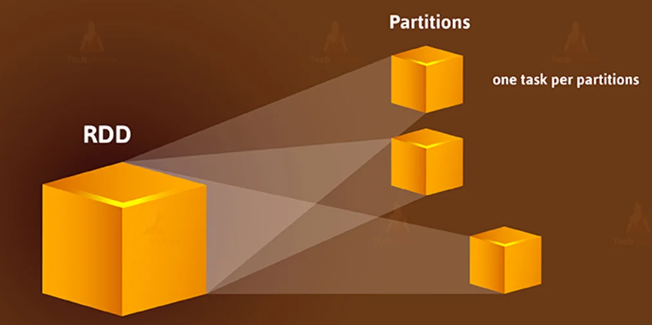

### **Partitions**
As mentioned above, RDDs are divided into small chunks called Partitions, so when you execute some action, a task is launched for each partition. This means that, the more the number of partitions, the more the parallelism. The good thing about spark is that you do not need to worry about the number of partitions that an RDD needs to be divided into. Spark automatically decides that for you unless you are working on a special project that requires you to specify the number of partitions when creating an RDD. As mentioned before, all of these partitions will be distributed across the many nodes of the network. 

### **Creating RDDs**
Creating RDDs is easy, they can be created either from an external source or by parallelizing collections in your driver. For example:


In [3]:
#make sure to upload the textfile.txt textfile into the content folder. 
#External Source
rdd_txtfile = sc.textFile("/content/data/")
#rdd_txtfile1 = sc.textFile("/content/textfile.txt",3)

The first line above creates an RDD from an external file. The second line does the same thing, the only difference is that there is a second argument(the number 3) parsed into the sc.textFile() method. The number three(3) specifies the number of partitions that needs to be created. 

**Remember, Spark can automatically partition RDDs for you, but you also have the choice to specify the number of partitions you want to create.**


In [ ]:
#Parallelized Collections
rdd_data = sc.parallelize(range(100))

The line above creates an RDD by parallelizing a range of numbers.  

### **RDD Operations**
There are two types of operations that you can perform on an RDD: **Transformations** and **Actions**

When a **transformation** operation is being performed,  some kind of function is applied to the existing RDD which then creates a new RDD. Since RDDs are immutable, therefore the RDD that you applied to the transformation function will not be modified. Instead, it will create a new one which keeps a pointer to the parent RDD. 

When you call a **transformation**, Spark is smart enough to not execute it immediately, instead, it creates a **lineage** that keeps track of what transformations will be applied on the RDD in question. 

On the other hand, the actions trigger the transformations to create an output that might just be displayed on the screen or saved in some specific location. 

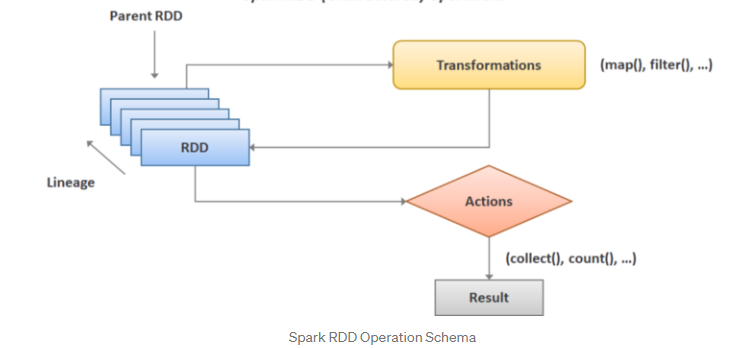

Some of the most common transformation methods are map(), flatMap(), and filter(). 
Some of the most common action methods are count(), take(), and collect()

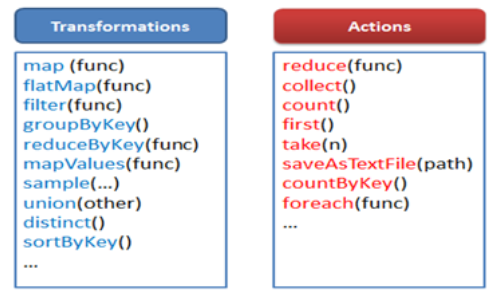

### **Working with Key-Value Pairs**

While most Spark operations work on RDDs containing any type of objects, a few special operations are only available on RDDs of key-value pairs. The most common ones are distributed “shuffle” operations, such as grouping or aggregating the elements by a key.

In Python, these operations work on RDDs containing built-in Python tuples such as (1, 2). Simply create such tuples and then call your desired operation.


### **Application Using the Word Count Example**

In [ ]:
#to import files you can manually upload them to colab 
#or use the code below to trigger and upload button
from google.colab import files
files.upload()


In [61]:
#creating rdd from textfile and using flatMap to tranform the data
#rdd_txtfile = sc.textFile("/content/textfile.txt").flatMap(lambda x:x.split())
punc='!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

#makes the rdd lowercase, no punct, split word by word
def cleanup(lines):
      lines = lines.lower()
      for p in punc:
        lines = lines.replace(p, '')
      lines = lines.split()
      return lines

rdd_txtfile = sc.textFile("/content/data/").flatMap(lambda x: cleanup(x))
#rdd1 = rdd_txtfile.map(Func)

In [ ]:
#mapping the words
#second transformation
mapping = rdd_txtfile.map(lambda x:(x,1))
#action to preview/trigger the transformation
mapping.collect()

In [ ]:
#third transformation 
#reduceByKey operation on key-value pairs to count how many times
counting = mapping.reduceByKey(lambda x,y:x+y)

#second action to preview/trigger the word count. 
counting.collect()

1. Read the data (all the files in the ‘data’ directory) into an RDD using the function textFile
2. Take only the “text” part of each file and count the frequency of all the words (convert the text into lowercase)
3. Remove (Filter) any word whose frequency is less than 3
4. Report the following
    1. The total size(the word count) of the output data(After filtering)
    2. the 5 most frequent words in all files. 
    3. The word with maximum frequency for each file (Individually)
    

In [43]:
# Remove (Filter) any word whose frequency is less than 3 
removed3 = counting.filter(lambda words: words[1] > 3)
removed3.collect()
removed3.saveAsTextFile('output_great3')

In [55]:
# Return the max length 
sum_removed3 = removed3.count()
print(sum_removed3)
sumRdd = removed3.reduceByKey(add)
print(sumRdd)

#parallel_removed3 = sc.parallelize(removed3)
sum_removed3 = removed3.map(lambda x : x[1]).sum()
print(sum_removed3)

53
PythonRDD[97] at RDD at PythonRDD.scala:53
601


In [59]:
top5 = removed3.top(5, key=lambda items: items[1])
print(top5)

[('the', 79), ('to', 55), ('a', 40), ('and', 31), ('in', 31)]


In [62]:
#creating rdd from textfile and using flatMap to tranform the data
#just adding a dup var and function for clarity
punc='!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

#makes the rdd lowercase, no punct, split word by word
def cleanup(lines):
      lines = lines.lower()
      for p in punc:
        lines = lines.replace(p, '')
      lines = lines.split()
      return lines

rdd1 = sc.textFile("/content/data/01.txt").flatMap(lambda x: cleanup(x))
rdd2 = sc.textFile("/content/data/02.txt").flatMap(lambda x: cleanup(x))
rdd3 = sc.textFile("/content/data/03.txt").flatMap(lambda x: cleanup(x))
rdd4 = sc.textFile("/content/data/04.txt").flatMap(lambda x: cleanup(x))
rdd5 = sc.textFile("/content/data/05.txt").flatMap(lambda x: cleanup(x))
rdd6 = sc.textFile("/content/data/06.txt").flatMap(lambda x: cleanup(x))
rdd7 = sc.textFile("/content/data/07.txt").flatMap(lambda x: cleanup(x))
rdd8 = sc.textFile("/content/data/08.txt").flatMap(lambda x: cleanup(x))
rdd9 = sc.textFile("/content/data/09.txt").flatMap(lambda x: cleanup(x))
rdd10 = sc.textFile("/content/data/10.txt").flatMap(lambda x: cleanup(x))

In [ ]:
#mapping the words
#second transformation
mapping1 = rdd1.map(lambda x:(x,1))
mapping1.collect()

mapping2 = rdd2.map(lambda x:(x,1))
mapping2.collect()

mapping3 = rdd3.map(lambda x:(x,1))
mapping3.collect()

mapping4 = rdd4.map(lambda x:(x,1))
mapping4.collect()

mapping5 = rdd5.map(lambda x:(x,1))
mapping5.collect()

mapping6 = rdd6.map(lambda x:(x,1))
mapping6.collect()

mapping7 = rdd7.map(lambda x:(x,1))
mapping7.collect()

mapping8 = rdd8.map(lambda x:(x,1))
mapping8.collect()

mapping9 = rdd9.map(lambda x:(x,1))
mapping9.collect()

mapping10 = rdd10.map(lambda x:(x,1))
mapping10.collect()

In [64]:
#third transformation 
#reduceByKey operation on key-value pairs to count how many times
counting1 = mapping1.reduceByKey(lambda x,y:x+y)
counting2 = mapping2.reduceByKey(lambda x,y:x+y)
counting3 = mapping3.reduceByKey(lambda x,y:x+y)
counting4 = mapping4.reduceByKey(lambda x,y:x+y)
counting5 = mapping5.reduceByKey(lambda x,y:x+y)
counting6 = mapping6.reduceByKey(lambda x,y:x+y)
counting7 = mapping7.reduceByKey(lambda x,y:x+y)
counting8 = mapping8.reduceByKey(lambda x,y:x+y)
counting9 = mapping9.reduceByKey(lambda x,y:x+y)
counting10 = mapping10.reduceByKey(lambda x,y:x+y)

In [65]:
removed_1 = counting1.filter(lambda words: words[1] > 3)
removed_2 = counting2.filter(lambda words: words[1] > 3)
removed_3 = counting3.filter(lambda words: words[1] > 3)
removed_4 = counting4.filter(lambda words: words[1] > 3)
removed_5 = counting5.filter(lambda words: words[1] > 3)
removed_6 = counting6.filter(lambda words: words[1] > 3)
removed_7 = counting7.filter(lambda words: words[1] > 3)
removed_8 = counting8.filter(lambda words: words[1] > 3)
removed_9 = counting9.filter(lambda words: words[1] > 3)
removed_10 = counting10.filter(lambda words: words[1] > 3)

In [66]:
top1 = removed_1.top(1, key=lambda items: items[1])
top2 = removed_2.top(1, key=lambda items: items[1])
top3 = removed_3.top(1, key=lambda items: items[1])
top4 = removed_4.top(1, key=lambda items: items[1])
top5 = removed_5.top(1, key=lambda items: items[1])
top6 = removed_6.top(1, key=lambda items: items[1])
top7 = removed_7.top(1, key=lambda items: items[1])
top8 = removed_8.top(1, key=lambda items: items[1])
top9 = removed_9.top(1, key=lambda items: items[1])
top10 = removed_10.top(1, key=lambda items: items[1])

print(top1)
print(top2)
print(top3)
print(top4)
print(top5)
print(top6)
print(top7)
print(top8)
print(top9)
print(top10)

[('the', 7)]
[('to', 9)]
[('the', 11)]
[('and', 5)]
[('to', 10)]
[('to', 9)]
[('the', 12)]
[('the', 9)]
[('the', 10)]
[('the', 7)]


In [44]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
